In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE

from taskpriors.sampler import sample_labels_from_features

In [2]:
# Settings
batch_size = 64
temperature = 1000.0
num_classes = 10
seed = 0
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [4]:
# Load dataset using torchvision's built-in Imagenette
dataset = datasets.Imagenette(root="./data", split="train", transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Build feature extractor from pretrained ResNet-18 (remove classification head)
backbone = models.resnet18(pretrained=True)
backbone.fc = torch.nn.Identity()  # Remove the final classification layer
model = backbone.to(device)

/Users/niketpatel/Library/Python/3.11/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/niketpatel/Library/Python/3.11/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Extract raw features for all samples
model.eval()
features = []
with torch.no_grad():
    for batch in dataloader:
        x = batch[0].to(device)
        feats = model(x).cpu().numpy()
        features.append(feats)
features = np.concatenate(features, axis=0)

In [11]:
tsne = TSNE(n_components=2, random_state=seed)
embeds = tsne.fit_transform(features)

In [21]:
sampled_labels = sample_labels_from_features(
    features,
    num_classes=num_classes,
    temperature=temperature* 5000,
    seed=seed,
)

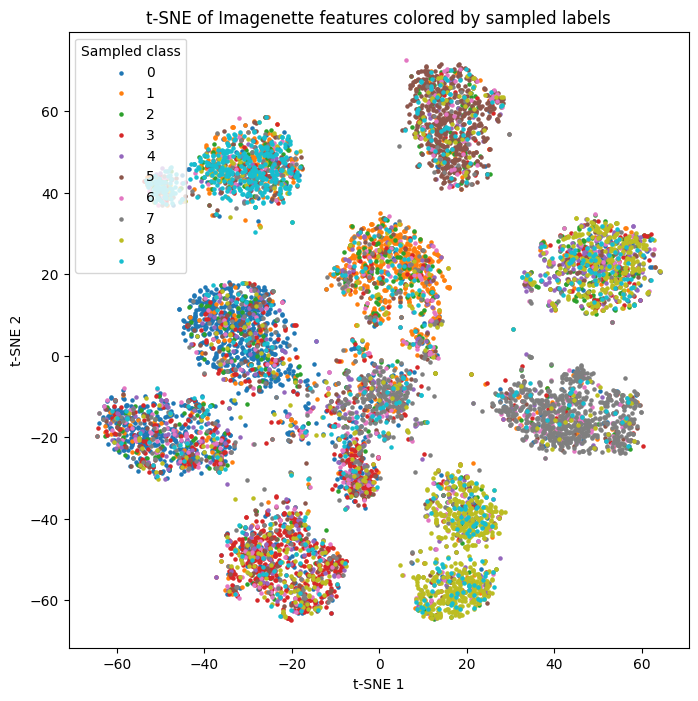

In [ ]:
plt.figure(figsize=(8, 8))
for c in range(num_classes):
    idx = sampled_labels == c
    plt.scatter(embeds[idx, 0], embeds[idx, 1], label=str(c), s=5)
plt.legend(title="Sampled class")
plt.title("t-SNE of Imagenette features colored by sampled labels")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()